---

# 3 Finding Best Routes (Q3)
Whenever you plan to fly to a specific city, your goal is to find the most efficient and fastest flight to reach your destination. In the system you are designing, the best route is defined as the one that minimizes the total distance flown to the greatest extent possible.
> In this task, you need to implement a function that, given an origin and destination city, determines the best possible route between them. To simplify, the focus will be limited to flights operating on a specific day.

Note: Each city may have multiple airports; in such cases, the function should calculate the best route for every possible airport pair between the two cities. For example, if city A has airports a1, a2, and city B has b1, b2, the function should compute the best routes for a1 → b1, a1 → b2, a2 → b1 and a2 → b2. If it's not possible to travel from one airport in the origin city to another airport in the destination city on that date, you must report it as well.

The function takes the following inputs:
1. Flights network
2. Origin city name
3. Destination city name
4. Considered Date (in yyyy-mm-dd format)

The function output:
1. A table with three columns: 'Origin _city_airport, 'Destination_city_airport', and the 'Best_route.

Note: In the "Best _route" column, we expect a list of airport names connected by →, showing the order in which they are to be visited during the optimal route. If no such route exists, the entry should display "No route found."

---

In [7]:
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import re
from collections import defaultdict
import folium
import requests
import time
from modules.graph import *
from modules.utils import *
from modules.shortest_path import *
from IPython.display import display
import random
import heapq
from collections import deque
import math
import scipy
from tabulate import tabulate


In [8]:
import modules.shortest_path
import pandas as pd
import numpy as np
df = pd.read_csv('Airports2.csv')
df = df.drop_duplicates(keep='last') # Drop duplicates, keeping the last entry

Having loaded the data and removed duplicate entries by keeping the last entries only, we can proceed with selecting only the relevant columns for the task of Question 3. Namely by selecting by only keeping the columns 'Origin_airport', 'Destination_airport', 'Fly_date', 'Origin_city', 'Destination_city', 'Distance' and making a new dataframe, **working_df**.

In [3]:
df.head()

,Origin_airport,Destination_airport,Origin_city,Destination_city,Passengers,Seats,Flights,Distance,Fly_date,Origin_population,Destination_population,Org_airport_lat,Org_airport_long,Dest_airport_lat,Dest_airport_long
0,MHK,AMW,"Manhattan, KS","Ames, IA",21,30,1,254,2008-10-01,122049,86219,39.140999,-96.670799,NaN,NaN
1,EUG,RDM,"Eugene, OR","Bend, OR",41,396,22,103,1990-11-01,284093,76034,44.124599,-123.211998,44.254101,-121.150002
2,EUG,RDM,"Eugene, OR","Bend, OR",88,342,19,103,1990-12-01,284093,76034,44.124599,-123.211998,44.254101,-121.150002
3,EUG,RDM,"Eugene, OR","Bend, OR",11,72,4,103,1990-10-01,284093,76034,44.124599,-123.211998,44.254101,-121.150002
4,MFR,RDM,"Medford, OR","Bend, OR",0,18,1,156,1990-02-01,147300,76034,42.374199,-122.873001,44.254101,-121.150002


In [9]:
# I need origin_airport, destination_airport, fly_date, origin_city, destination_city, and distance
working_df = df[['Origin_airport', 'Destination_airport', 'Fly_date', 'Origin_city', 'Destination_city', 'Distance']].copy()

Performing some sanity checks below:

In [5]:
working_df.isna().sum()

Origin_airport         0
Destination_airport    0
Fly_date               0
Origin_city            0
Destination_city       0
Distance               0
dtype: int64

In [6]:
working_df.dtypes

Origin_airport         object
Destination_airport    object
Fly_date               object
Origin_city            object
Destination_city       object
Distance                int64
dtype: object

In [7]:
print(f"Any empty values in 'Origin_airport' column: {sum(working_df.Origin_airport == "")}") # check if there are empty strings in Origin_airport
print(f"Any empty values in 'Destination_airport' column: {sum(working_df.Destination_airport == "")}") # check if there are empty strings in Destination_airport
print(f"Any empty values in 'Fly_date' column: {sum(working_df.Fly_date == "")}") # check if there are empty strings in Fly_date
print(f"Any empty values in 'Origin_city' column: {sum(working_df.Origin_city == "")}") # check if there are empty strings in Origin_city
print(f"Any empty values in 'Destination_city' column: {sum(working_df.Destination_city == "")}") # check if there are empty strings in Destination_city
print(f"Any NA value in 'Distance' column: {working_df.Distance.isna().sum()}") # check if there are empty strings in Distance

Any empty values in 'Origin_airport' column: 0
Any empty values in 'Destination_airport' column: 0
Any empty values in 'Fly_date' column: 0
Any empty values in 'Origin_city' column: 0
Any empty values in 'Destination_city' column: 0
Any NA value in 'Distance' column: 0


In [10]:
working_df.Origin_airport = working_df.Origin_airport.str.strip()
working_df.Destination_airport = working_df.Destination_airport.str.strip()
working_df.Fly_date = working_df.Fly_date.str.strip()
working_df.Origin_city = working_df.Origin_city.str.strip()
working_df.Destination_city = working_df.Destination_city.str.strip()

Because the algorithm we will use to find the shortest path in terms of distances requires non negative weights (distances), referring to Dijkstra's Algorithm, we have to ensure that no distance in the dataframe is negative and if, a few of them are negative, perhaps due to errors, we will remove those records.

In [11]:
working_df.Distance = working_df.Distance.astype(int)
print(f"Is there any record of flight with negative distance? Answer: {'Yes' if np.any(working_df.Distance < 0) else 'No'}")

Is there any record of flight with negative distance? Answer: No


We will now proceed to convert our dataframe to a __network__ of flights by making use of NetworkX data structure. We will create a flight network, using the `create_flight_network` defined in __shortest_path__ module, that takes in a dataframe and returns a Directed Graph (based on NetworkX data structure) along with relevant nodes, edges, and *data*.

In [222]:
help(modules.shortest_path.create_flight_network)
flight_network = modules.shortest_path.create_flight_network(working_df)

Help on function create_flight_network in module modules.shortest_path:

create_flight_network(working_df)
    Input:
    working_df: pd.DataFrame, the working dataframe
    
    Output:
    G: nx.DiGraph, the flight network
    
    About:
    This function creates a directed graph using the networkx library.
    The nodes of the graph are the airports and the edges are the flights between the airports.
    The graph has the following attributes:
    - Node attributes: city
    - Edge attributes: distance, date



100%|██████████| 3565050/3565050 [00:06<00:00, 570677.01it/s]


100%|██████████| 30331/30331 [00:00<00:00, 1045929.37it/s]


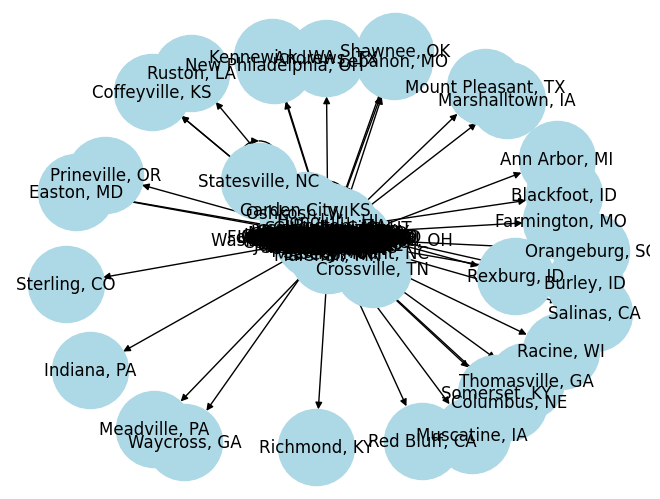

In [16]:
city_max_distance_df = working_df.loc[working_df.groupby(['Origin_city', 'Destination_city'])['Distance'].idxmax()]
flight_network = modules.shortest_path.create_city_flight_network(city_max_distance_df)

nx.draw(flight_network.to_networkx_digraph(), with_labels=True, node_color="lightblue", node_size=3000)

In [140]:
def degree_centrality(G, node):
    '''
    Function that calculates the degree centrality of a node based on the number of neighbors
    Inputs:
    - G (nx.DiGraph): graph of the flight network
    - node (str): node of the airport
    Outputs:
    - int: degree centrality of the node, number of neighbors
    '''
    return G.degree(node) / (G.number_of_nodes()-1)

def closeness_centrality(G, node):
    '''
    Function that calculates the closeness centrality of a node
    Inputs:
    - G (nx.DiGraph): graph of the flight network
    - node (str): node of the airport
    Outputs:
    - int: closeness centrality of the node
    '''
    distances, _ = deploy_dijkstra(G, node) # compute distances to each other node
    reachable = [x for x in distances.values() if x < float('inf')] # keep only reachable nodes
    if len(reachable) <=1: # if there are no reachable nodes, return 0
        return 0
    normalization = (G.number_of_nodes() - 1) / (len(reachable) - 1) # optional
    return (G.number_of_nodes()-1) / sum(reachable) * normalization

def betweenness_centrality(G, node=None):
    '''
    Function that calculates the betweenness centrality of a node
    Inputs:
    - G (nx.DiGraph): graph of the flight network
    - node (str): node of the airport
    Outputs:
    - int: betweenness centrality of the node if indicated, all betweenness centralities otherwise
    '''
    C_B = defaultdict(float) # initialize default dictionaries of betwenness centrality scores

    # Iterate over source nodes s
    for s in G.nodes:

        # Initializations
        distances = {x: float('inf') for x in G.nodes} # intialize distances to s (lengths of shortest paths)
        distances[s] = 0 # set distance of s to itself to 0
        predecessors = defaultdict(list) # initialize defaultdict of predecessors
        pq = [(0,s)] # initialize priority queue
        num_shortest_paths = defaultdict(int) # initialize dictionary of numbers of shortest paths
        num_shortest_paths[s] = 1 # number of shortest paths of source is 1
        backtrack_stack = deque() # initialize empty stack for backtracking

        # Convert priority queue into a heap
        heapq.heapify(pq)
        
        #print(f'Computing Dijkstra for airport {s} now.')

        # Dijkstra loop
        while len(pq)>0:
            # Extract tuple (distance, node) with smallest distance from the heap
            current_distance, current_node = heapq.heappop(pq)
            # Add current_node to backtrack_stack
            backtrack_stack.append(current_node)
            # If the current distance is larger than the distance of the current node
            if current_distance > distances[current_node]:
                continue # Skip the rest of the loop

            # Iterate over the neighbors of current_node
            for neighbor in G.successors(current_node):
                
                #print(f'Analyzing neighbor {neighbor} of {current_node}')

                # Compute the distance do the neighbor using the 'distance' attribute
                edge_weight = G[current_node][neighbor]['distance']
                # Compute new distance
                new_distance = current_distance + edge_weight
                # See if the new distance is smaller than the previous distance to the neighbor
                if distances[neighbor] > new_distance:
                    # Update distance of this neighbor to the source s
                    distances[neighbor] = new_distance
                    # Update number of shortest paths from s to neighbor
                    num_shortest_paths[neighbor] = num_shortest_paths[current_node]
                    # Update priority queue, pushing the neighbor with the new distance
                    heapq.heappush(pq, (new_distance, neighbor))
                    # Update predecessors
                    predecessors[neighbor] = [current_node]
                # See if the new distance is equally long as the previous one
                elif distances[neighbor] == new_distance:
                    # Update number of shortest paths from source to the neighbor
                    num_shortest_paths[neighbor] += num_shortest_paths[current_node]
                    # Update predecessors
                    predecessors[neighbor].append(current_node)
            
        # Initialize dictionary of dependencies
        dependencies = defaultdict(float)

        #print(f'Backtracking for airport {s} now.')
        
        # Backpropagation through the graph to find dependencies
        while backtrack_stack:
            # Take last element from the stack
            current_node = backtrack_stack.pop()
            # Iterate over the predecessors of the current node
            for predecessor in predecessors[current_node]:
                # Update dependency of source s on predecessor
                dependencies[predecessor] += (num_shortest_paths[predecessor] / num_shortest_paths[current_node]) * (1 + dependencies[current_node])                # If the current node is not the source node
            if current_node != s:
                # Update betweenness centrality
                C_B[current_node] += dependencies[current_node]

    # Compute normalization
    n = G.number_of_nodes()
    normalization = (n-1) * (n-2)

    # Normalize betweenness centralities
    for key in C_B.keys():
        C_B[key] /= normalization

    # return betweenness centrality of target node
    if node:
        return C_B[node]
    return C_B
    

def pagerank(G, node, a=0.5, seed=42, T=10000):
    '''
    Function that calculates the betweenness centrality of a node
    Inputs:
    - G (nx.DiGraph): graph of the flight network
    - node (str): starting node
    - a (int): parameter in [0,1]
    - seed (int): random seed
    - T (int): nuber of steps
    Outputs:
    - int: betweenness centrality of the node
    '''
    random.seed(seed) # set random seed
    t = 1
    current = node # starting node
    freq = defaultdict(int) # initialize defaultdict to measure the frequency with which a node is seen

    # Random walk through the airport graph
    while t<T+1:
        coin_flip = random.choices([0, 1], weights=[1-a, a], k=1)[0] # flip a coin

        # If outcome is 0, go to a random out-neighbor of the current node
        if coin_flip==0:
            current = random.choice(list(G.successors(node)))
        
        # If outcome is 1, go to a random node
        if coin_flip==1:
            current = random.choice(list(G.nodes))
        
        freq[current] +=1
        t += 1
    
    # Set the Pagerank
    Pagerank = defaultdict(int)
    for u in G.nodes:
        Pagerank[u] = freq[u] / T

    return Pagerank[node]

In [141]:
pagerank(flight_network,'LGA')

0.0035

In [136]:
nx.pagerank(flight_network)['LGA']

0.003117599593425756

In [133]:
def betweenness_centrality(G):
    """
    Calculate the betweenness centrality for a directed, weighted G.

    Parameters:
        G: A directed, weighted Graph.

    Returns:
        dict: A dictionary with nodes as keys and their betweenness centrality as values.
    """
    centrality = dict.fromkeys(G, 0.0)  # Initialize betweenness centrality for all nodes as 0.0
    all_nodes = G  # Get all nodes from the graph

    for start_node in all_nodes:  # Iterate over each node as the start node
        visited_stack = []  # Stack to keep track of nodes visited in reverse order
        predecessors = {node: [] for node in G}  # Initialize predecessors of each node as an empty list
        path_count = dict.fromkeys(G, 0.0)  # Initialize path counts for each node as 0.0
        shortest_distances = {}  # Store shortest distances from the start node
        path_count[start_node] = 1.0  # Set the path count of the start node to 1.0
        push, pop = heappush, heappop  # Import heap operations for the priority queue
        seen_distances = {start_node: 0}  # Store the minimum distance to the start node
        node_counter = count()  # Counter for unique IDs to resolve ties in the priority queue
        priority_queue = []  # Initialize the priority queue
        push(priority_queue, (0, next(node_counter), start_node, start_node))  # Add the start node to the priority queue

        while priority_queue:  # Process the priority queue until empty
            (current_distance, _, from_node, current_node) = pop(priority_queue)  # Pop the smallest distance node
            if current_node in shortest_distances:  # Skip if the node has already been finalized
                continue
            path_count[current_node] += path_count[from_node]  # Update the path count for the current node
            visited_stack.append(current_node)  # Add the current node to the stack for later processing
            shortest_distances[current_node] = current_distance  # Finalize the shortest distance to the current node
            for neighbor, _ in G[current_node].items():  # Iterate over all neighbors of the current node
                distance_to_neighbor = current_distance + G.edges[current_node, neighbor]['distance']  # Calculate distance to the neighbor
                if neighbor not in shortest_distances and (neighbor not in seen_distances or distance_to_neighbor < seen_distances[neighbor]):
                    seen_distances[neighbor] = distance_to_neighbor  # Update the seen distance to the neighbor
                    push(priority_queue, (distance_to_neighbor, next(node_counter), current_node, neighbor))  # Push the neighbor to the queue
                    path_count[neighbor] = 0.0  # Initialize the path count for the neighbor
                    predecessors[neighbor] = [current_node]  # Update the predecessor list for the neighbor
                elif distance_to_neighbor == seen_distances[neighbor]:  # If another shortest path is found
                    path_count[neighbor] += path_count[current_node]  # Increment the path count for the neighbor
                    predecessors[neighbor].append(current_node)  # Add the current node to the predecessor list

        dependencies = dict.fromkeys(visited_stack, 0)  # Initialize dependency values for all nodes in the stack
        while visited_stack:  # Process nodes in reverse order of their finishing times
            current_node = visited_stack.pop()  # Pop a node from the stack
            coefficient = (1 + dependencies[current_node]) / path_count[current_node]  # Calculate the coefficient for dependency accumulation
            for from_node in predecessors[current_node]:  # Iterate over all predecessors of the current node
                dependencies[from_node] += path_count[from_node] * coefficient  # Accumulate dependencies for the predecessor
            if current_node != start_node:  # Skip the start node when updating centrality
                centrality[current_node] += dependencies[current_node]  # Update the centrality for the current node

    total_nodes = len(G)  # Get the total number of nodes in the graph
    scale_factor = 1 / ((total_nodes - 1) * (total_nodes - 2)) if total_nodes > 2 else None  # Calculate the normalization scale factor
    if scale_factor:  # If the scale factor is valid
        for node in centrality:  # Iterate over all nodes
            centrality[node] *= scale_factor  # Apply normalization to the centrality values

    return centrality  # Return the betweenness centrality dictionary


In [134]:
betweenness_centrality(flight_network)['LGA']

0.004842129824535282

In [51]:
nx.betweenness_centrality(flight_network,weight='distance')['LGA']

0.004842129824535282

In [143]:
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import random

def analyze_flight_network(network, c1, c2):
    """
    Analyze the flight network, identify communities, visualize identified communities and check whether c1 and c2 belong to the same community.
    Args:
        network (CustomDiGraph): The flight network graph.
        c1 (str): Name of the first city.
        c2 (str): Name of the second city.
    """

    def custom_louvain_algorithm(network):
        #Total weight of edges (since the network is unweighted, each edge counts as 1)
        total_weight = network.num_edges()
        # Initialize communities: each node starts in its own community
        communities = {node: {node} for node in network.get_nodes()}
       # Track which community each node belongs to
        node_to_community = {node: node for node in network.get_nodes()}

        def move_node(node):
            # Track the current community of the node
            current_community = node_to_community[node]
            # Count the weights of edges connecting the node to each community
            community_weights = Counter()

            # Iterate through the neighbors of the node
            for neighbor in network.get_neighbors(node):
                # Get the community of the neighbor
                neighbor_community = node_to_community[neighbor]
                # Increment the weight of the connection to this community
                community_weights[neighbor_community] += 1

            # Variables to track the best gain and the corresponding community
            best_gain = 0
            best_community = current_community

            # Evaluate modularity gain for moving the node to neighboring communities
            for target_community, edge_weight in community_weights.items():
                if target_community != current_community:
                    #Calculate the total degree of nodes in the target community
                    total_degree = sum(network.out_degree(u) for u in communities[target_community])
                    #Get the out-degree of the current node
                    current_degree = network.out_degree(node)

                    # Compute the modularity gain for moving the node
                    gain =(edge_weight /total_weight) - (current_degree * total_degree)/ (2* total_weight ** 2)
                    #Update the best gain and community if the gain is greater
                    if gain > best_gain:
                        best_gain = gain
                        best_community = target_community

            # Move the node to the best community if there's a positive gain
            if best_community != current_community:
                communities[current_community].remove(node)
                communities[best_community].add(node)
                node_to_community[node] = best_community

        # Perform 10 iterations to refine communities, a fixed number of iterations is used, since in most of cases, the algorithm can converge within this number
        for _ in range(10):
            for node in network.get_nodes():
                move_node(node)

        #Aggregate nodes into final communities
        aggregated_communities = defaultdict(set)
        for node, community in node_to_community.items():
            aggregated_communities[community].add(node)

        # Reorder community key 
        final_communities = {i: nodes for i, nodes in enumerate(aggregated_communities.values())}
        return final_communities


    #Identify communities
    communities = custom_louvain_algorithm(network)

    #Check if city1 and city2 belong to the same community
    city1_community, city2_community = None, None

    for community_id, nodes in communities.items():
        if c1 in nodes:
            city1_community = community_id
        if c2 in nodes:
            city2_community = community_id

    same_community = city1_community == city2_community



    # Visualize the graph
    def visualize_graph(graph, communities):
        nx_graph = graph.to_networkx_digraph()
        pos = nx.spring_layout(nx_graph)

        #Original graph
        plt.figure(figsize=(15, 8))

        plt.subplot(1, 3, 1)
        nx.draw(
            nx_graph, pos, with_labels=True, node_color="lightblue", edge_color="black",
            node_size=800, font_size=10, font_color="black"
        )
        plt.title("Original Flight Network")

        # Partitioned graph
        plt.subplot(1, 3, 2)
        # Assign a unique random color to each community
        community_colors = {community_id: "#%06x" % random.randint(0, 0xFFFFFF) for community_id in communities}
        node_colors = [community_colors[community_id] for node in nx_graph.nodes() for community_id, nodes in communities.items() if node in nodes]

        nx.draw(
            nx_graph, pos, with_labels=True, node_color=node_colors, edge_color="black",
            node_size=800, font_size=10, font_color="white"
        )
        plt.title("Flight Network with Communities")

        # Legend
        plt.subplot(1, 3, 3)
        plt.axis('off')
        legend_handles = [
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=f"Community {community_id}")
            for community_id, color in community_colors.items()
        ]
        plt.legend(handles=legend_handles, loc='center', title="Communities")

        plt.tight_layout()
        plt.show()



    #Print results
    print(f"The flight network has been partitioned in {len(communities)} communities.")

    community_list = []
    for key, values in communities.items():
        community_list.append({"Community Number": key, "Number of cities": len(values), "Cities": ", ".join(values)})
    community_df = pd.DataFrame(community_list)
    # Convert DataFrame to a tabular string format
    tabular_view = tabulate(community_df, headers="keys", tablefmt="grid", showindex=False)
    print(tabular_view)

    visualize_graph(network, communities)
    print(f"Are {c1} and {c2} in the same community?", same_community)


analyze_flight_network(flight_network, "MUT", "HUA")

AttributeError: 'DiGraph' object has no attribute 'num_edges'

The flight network has been partitioned in 30 communities.


Community Number,Number of cities,Cities
0,267,"Helena, MT, Lawrence, KS, Brunswick, GA, Harrison, AR, Liberal, KS, Alexandria, LA, Connersville, IN, Big Spring, TX, Las Vegas, NV, Lawrenceburg, TN, Hutchinson, KS, Nacogdoches, TX, Panama City, FL, Lake Charles, LA, Little Rock, AR, Altoona, PA, Greenwood, SC, Los Alamos, NM, Warrensburg, MO, Youngstown, OH, Clovis, NM, Poughkeepsie, NY, Chillicothe, OH, Yakima, WA, Grand Forks, ND, Gillette, WY, Sedalia, MO, Big Rapids, MI, Pierre, SD, Rocky Mount, NC, Georgetown, SC, Great Bend, KS, Selma, AL, Newark, NJ, Cape Girardeau, MO, Jackson, MI, Billings, MT, Bloomington, IN, Enid, OK, Sweetwater, TX, Eagle Pass, TX, Wheeling, WV, New Iberia, LA, Eau Claire, WI, Farmington, NM, Fergus Falls, MN, Laurel, MS, Borger, TX, Rock Springs, WY, Longview, TX, Columbia, SC, Mountain Home, AR, Ocala, FL, Minot, ND, Sturgis, MI, Escanaba, MI, Medford, OR, Russellville, AR, Paducah, KY, Santa Ana, CA, Springfield, OH, Williamsport, PA, Erie, PA, Staunton, VA, Elkhart, IN, Punta Gorda, FL, Worcester, MA, Des Moines, IA, Alpena, MI, Pocatello, ID, Madera, CA, Springfield, IL, Crescent City, CA, Spartanburg, SC, Iron Mountain, MI, Havre, MT, Brownwood, TX, Reno, NV, Price, UT, Statesville, NC, Sebastian, FL, Brigham City, UT, Peru, IN, Plattsburgh, NY, Marshall, MO, Eugene, OR, Kankakee, IL, Wilmington, NC, York, PA, Flagstaff, AZ, Portsmouth, OH, Rochester, MN, Tullahoma, TN, Bellefontaine, OH, Scottsbluff, NE, Shelby, NC, Marion, OH, Lock Haven, PA, Portland, ME, Napa, CA, Las Cruces, NM, Columbus, OH, Tifton, GA, Shelbyville, TN, San Jose, CA, Johnstown, PA, Gadsden, AL, Glasgow, KY, Anderson, IN, Ames, IA, Pine Bluff, AR, Houston, TX, Albany, GA, Galesburg, IL, Danville, IL, Show Low, AZ, Juneau, AK, Batesville, AR, Detroit, MI, Bennington, VT, Decatur, IL, Walla Walla, WA, Rockford, IL, Mount Sterling, KY, Astoria, OR, Hanford, CA, Marion, IN, Mankato, MN, Gary, IN, Waco, TX, Port Angeles, WA, Fort Leonard Wood, MO, London, KY, Cleveland, OH, Lexington, KY, Olympia, WA, Madisonville, KY, Alamogordo, NM, Valdosta, GA, Wapakoneta, OH, Lake Havasu City, AZ, Hays, KS, San Luis Obispo, CA, Brownsville, TX, Mitchell, SD, Hickory, NC, Wichita, KS, Searcy, AR, Jackson, WY, Albany, OR, Huron, SD, Americus, GA, Orlando, FL, Reading, PA, Lewisburg, TN, Lima, OH, Santa Rosa, CA, Naples, FL, Greenwood, MS, Bradford, PA, Mount Vernon, WA, Lewiston, ID, Abilene, TX, Lexington, NE, Salisbury, NC, St. Cloud, MN, Wenatchee, WA, Mason City, IA, Jonesboro, AR, Davenport, IA, Gainesville, FL, Yankton, SD, Athens, OH, Mount Vernon, IL, Dickinson, ND, Statesboro, GA, Pendleton, OR, Rutland, VT, Truckee, CA, Pullman, WA, Dodge City, KS, Hobbs, NM, Burlington, IA, Mansfield, OH, Nashville, TN, Kokomo, IN, Roanoke, VA, Columbus, IN, Riverton, WY, Altus, OK, Bay City, TX, Greeneville, TN, Frankfort, KY, Lewiston, ME, Roseburg, OR, Appleton, WI, Wooster, OH, Washington Court House, OH, Miami, FL, Mount Pleasant, MI, Butte, MT, Dyersburg, TN, Owatonna, MN, Portland, OR, Bridgeport, CT, Ogden, UT, Kearney, NE, Greenville, NC, Carbondale, IL, Ardmore, OK, Tuscaloosa, AL, Hot Springs, AR, Ruidoso, NM, Gallup, NM, Norfolk, NE, Santa Barbara, CA, Oak Harbor, WA, Richmond, VA, Montgomery, AL, Ellensburg, WA, Roswell, NM, Auburn, IN, Fort Dodge, IA, Anniston, AL, Moses Lake, WA, Harrisburg, PA, Branson, MO, Findlay, OH, Montrose, CO, Lancaster, PA, Kirksville, MO, Elizabethtown, KY, Oneonta, NY, Chattanooga, TN, Cumberland, MD, Tucson, AZ, Modesto, CA, Watertown, NY, Blytheville, AR, Marshall, TX, Talladega, AL, Hudson, NY, Hagerstown, MD, Bangor, ME, Sikeston, MO, Lakeland, FL, Victoria, TX, Sheridan, WY, Safford, AZ, Seymour, IN, Ottumwa, IA, Morristown, TN, Storm Lake, IA, La Grande, OR, Kodiak, AK, Goldsboro, NC, El Dorado, AR, Cadillac, MI, Rome, GA, Elizabeth City, NC, Spokane, WA, La Crosse, WI, Brookings, SD, Sterling, IL, Sheboygan, WI, Key West, FL, Athens, GA"
1,267,"Terre Haute, IN, Chico, CA, College Station, TX, Al

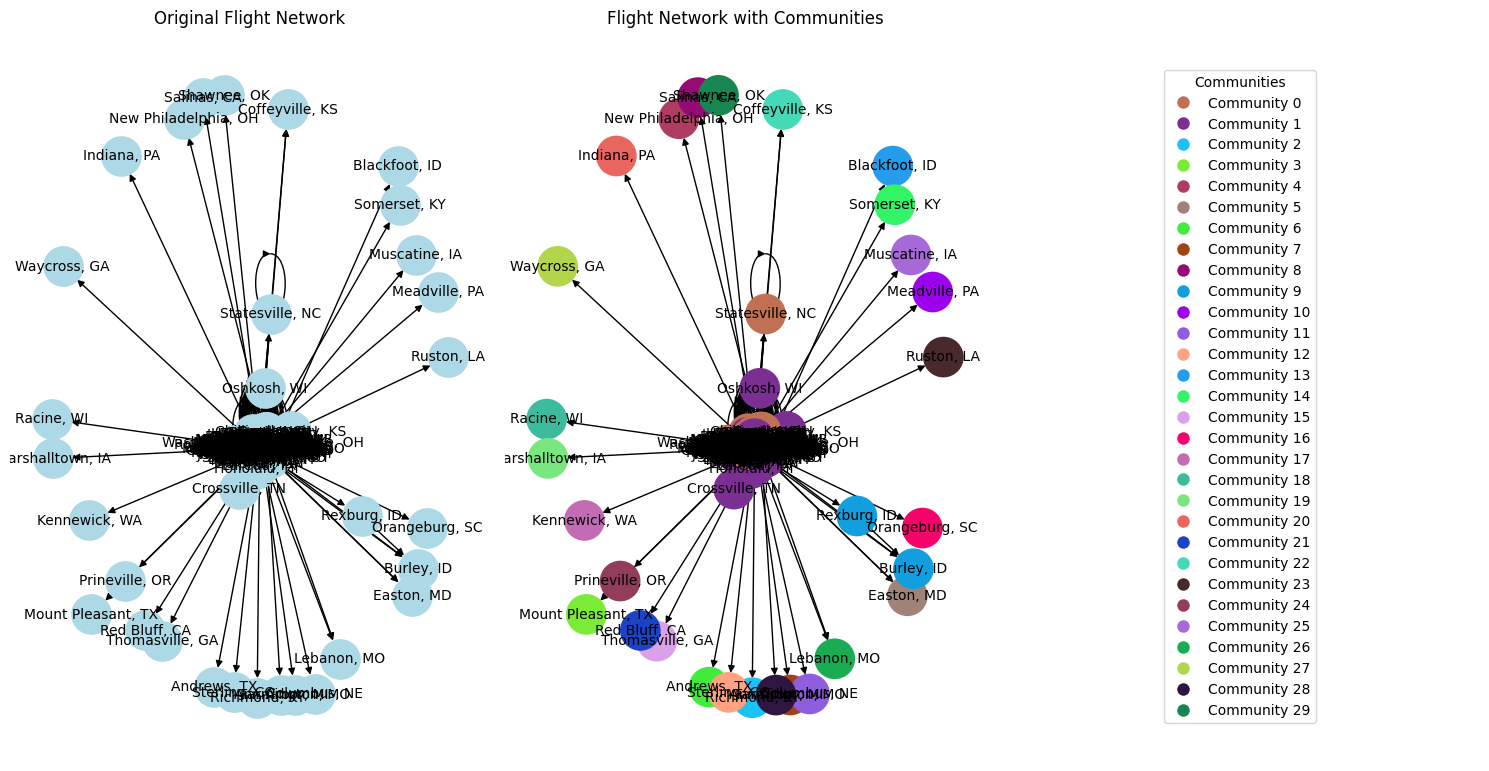

Are Ames, IA and Bend, OR in the same community? False


In [25]:
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import random

def analyze_flight_network(network, c1, c2):
    """
    Analyze the flight network, identify communities, visualize identified communities and check whether c1 and c2 belong to the same community.
    Args:
        network (CustomDiGraph): The flight network graph.
        c1 (str): Name of the first city.
        c2 (str): Name of the second city.
    """

    def custom_louvain_algorithm(network):
        """
        Custom implementation of the Louvain algorithm for community detection.
        Adapted to work with the CustomDiGraph class.
        """
        #Total weight of edges
        total_weight = sum(weight for _, _, weight in network.get_edges())

        # Initialize communities: each node starts in its own community
        communities = {node: {node} for node in network.get_nodes()}
        node_to_community = {node: node for node in network.get_nodes()}  # Track the community of each node

        def move_node(node):
            """
            Move a node to the community where it gains the most modularity.
            """
            current_community = node_to_community[node]

            # Count the weighted edges connecting the node to each community
            community_weights = Counter()
            for neighbor, weight in network.get_neighbors(node).items():
                neighbor_community = node_to_community[neighbor]
                community_weights[neighbor_community] += weight

            #Evaluate modularity gain for moving the node to neighboring communities
            best_gain = 0
            best_community = current_community
            for target_community, edge_weight in community_weights.items():
                if target_community != current_community:
                    total_degree = sum(
                        sum(network.get_neighbors(u).values())
                        for u in communities[target_community]
                    )
                    current_degree = sum(network.get_neighbors(node).values())

                    gain = (edge_weight / total_weight- (current_degree * total_degree) / (2 * total_weight ** 2) )
                    if gain > best_gain:
                        best_gain = gain
                        best_community = target_community

            # Move the node to the best community if there's a positive gain
            if best_community != current_community:
                communities[current_community].remove(node)
                communities[best_community].add(node)
                node_to_community[node] = best_community

        # Iteratively refine communities
        for _ in range(10):
            for node in network.get_nodes():
                move_node(node)

        # Aggregate nodes into final communities
        aggregated_communities = defaultdict(set)
        for node, community in node_to_community.items():
            aggregated_communities[community].add(node)

        #Number community keys
        final_communities = {i: nodes for i, nodes in enumerate(aggregated_communities.values())}
        return final_communities
    # Identify communities using the custom Louvain algorithm
    communities = custom_louvain_algorithm(flight_network)
    #Check if city1 and city2 belong to the same community
    city1_community, city2_community = None, None

    for community_id, nodes in communities.items():
        if c1 in nodes:
            city1_community = community_id
        if c2 in nodes:
            city2_community = community_id

    same_community = city1_community == city2_community



    # Visualize the graph
    def visualize_graph(graph, communities):
        nx_graph=graph.to_networkx_digraph()
        pos = nx.spring_layout(nx_graph)

        #Original graph
        plt.figure(figsize=(15, 8))

        plt.subplot(1, 3, 1)
        nx.draw(
            nx_graph, pos, with_labels=True, node_color="lightblue", edge_color="black",
            node_size=800, font_size=10, font_color="black"
        )
        plt.title("Original Flight Network")

        # Partitioned graph
        plt.subplot(1, 3, 2)
        # Assign a unique random color to each community
        community_colors = {community_id: "#%06x" % random.randint(0, 0xFFFFFF) for community_id in communities}
        node_colors = [community_colors[community_id] for node in nx_graph.nodes() for community_id, nodes in communities.items() if node in nodes]

        nx.draw(
            nx_graph, pos, with_labels=True, node_color=node_colors, edge_color="black",
            node_size=800, font_size=10, font_color="black"
        )
        plt.title("Flight Network with Communities")

        # Legend
        plt.subplot(1, 3, 3)
        plt.axis('off')
        legend_handles = [
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=f"Community {community_id}")
            for community_id, color in community_colors.items()
        ]
        plt.legend(handles=legend_handles, loc='center', title="Communities")

        plt.tight_layout()
        plt.show()



    #Print results
    print(f"The flight network has been partitioned in {len(communities)} communities.")

    community_list = []
    for key, values in communities.items():
        community_list.append({"Community Number": key, "Number of cities": len(values), "Cities": ", ".join(values)})
    community_df = pd.DataFrame(community_list)
    display(community_df.style.hide(axis='index'))

    visualize_graph(network, communities)
    print(f"Are {c1} and {c2} in the same community?", same_community)


analyze_flight_network(flight_network, "Ames, IA", "Bend, OR")




In [26]:
def label_propagation(network, max_iterations=10):
    #Each city as its own coomunity
    labels = {node: node for node in network.get_nodes()}

    for _ in range(max_iterations):
        #Shuffle nodes to ensure random processing order
        nodes = list(network.get_nodes())
        random.shuffle(nodes)
        
        has_changed = False
        
        for node in nodes:
            #Count labels of neighbors
            neighbor_labels = [labels[neighbor] for neighbor in network.get_neighbors(node)]
            if neighbor_labels:
                most_common_label = Counter(neighbor_labels).most_common(1)[0][0]
                
                #Update label if it differs from the current label
                if labels[node] != most_common_label:
                    labels[node] = most_common_label
                    has_changed = True
        
        #Stop if no labels have changed
        if not has_changed:
            break

    #Aggregate nodes into communities
    communities = defaultdict(set)
    for node, label in labels.items():
        communities[label].add(node)

    #Number communities
    final_communities = {i: nodes for i, nodes in enumerate(communities.values())}
    return final_communities

In [27]:
label_propagation_communities = label_propagation(flight_network)

print(f"The flight network has been partitioned in {len(label_propagation_communities)} communities.")
community_list = []
for key, values in label_propagation_communities.items():
    community_list.append({"Community Number": key, "Number of cities": len(values), "Cities": ", ".join(values)})
community_df = pd.DataFrame(community_list)
display(community_df.style.hide(axis='index'))


The flight network has been partitioned in 29 communities.


Having prepared the flight network, we can get a brief look at the problem we are trying to solve: <br>

__Generic Problem__: Single-Source Shortest Paths.

__Input__: A directed graph $G = (V, E)$, a starting vertex $s \in V$, and a nonnegative length $l_e$ for each edge $e \in E$. <br>
__Output__: $dist(s,v)$ for every vertex $v \in V$. <br> <br>

---

<h4 style="text-align:center;">Pseudocode for the Algorithm Deployed: <i>(deploy_dijkstra in the shortest_path module)</i></h4>

$$Dijkstra's Algorithm$$

**Input:**
- A graph $ G = (V, E) $ in adjacency-list form. Each edge $ e = (u, v) $ must have a non-negative weight $ l_{u,v} $.
- A source node $ s \in V $.

**Output:**
- `distances[v]`: The shortest distance from $ s $ to every node $ v $.
- `predecessors[v]`: The predecessor of $ v $ in the shortest path, which we will use for path reconstruction.


__Steps:__

1. **Initialization:**
    > Create a `distances` dictionary: <br>
     - distances[v] = $+\infty$ for all $ v \in V $ (because we don't know the shortest distance).<br>
     - distances[s] = 0 (distance to the source is zero).<br>
    > Create a `predecessors` dictionary:<br>
     - predecessors[v] = None, for all $ v \in V $ (initially, we don't know the path leading to each V so we equate each to None).<br>
    > Create a `priority_queue` (min-heap) and insert $(0, s)$, where first value in the tuple is the initialised distance and second value in the name of the Node. *The queue ensures that the node with the smallest known distance is processed first.*<br>

2. **Main Loop:** <br>
    While `priority_queue` is not empty: <br>
    > Extract the node with the smallest distance by popping the first tuple from the queue: `current_distance, current_node = heapq.heappop(priority_queue)`. <br>
    > If `current_distance > distances[current_node]`, skip this node (stale entry). <br>
    > For each neighbor $ v $ of `current_node`:<br>
       - Retrieve the edge weight (distance): $ l_{current\_node, v} $.<br>
       - Compute the *tentative* distance:<br>
         - `new_distance = current_distance + l_{current_node, v}`.<br>
       - If `new_distance < distances[v]`:<br>
         - Update `distances[v] = new_distance`.<br>
         - Update `predecessors[v] = current_node` so that we get a record of what preceeded the node in ordering of distance.<br>
         - Push `(new_distance, v)` into the `priority_queue` so that we can iteratively start from the next node with the smallest distance.<br>

3. **Returns:**
   - `distances`: The shortest distance from $ s $ to every reachable node.
   - `predecessors`: The predecessor of each node for path reconstruction.

__Postcondition__: for every vertex $v$, the value $len(v)$ equals the true shortest-path distance $dist(s, v)$.

---

In the the __shortest_path__ module, we have created a function `deploy_dijkstra` using the pseudocode outlined about. It takes a flight network and a source airport code as input, and returns the shortest paths from the source airport to all other airports in the network using Dijkstra's algorithm. For more information, please refer to the docstring of the function using the following command: `help(shortest_path.deploy_dijkstra)` or navigate to the __shortest_path__ module and check the docstring of the function. <br>

In [12]:
print(f"Printing the Docstring of the function deploy_dijkstra for reference:")
help(shortest_path.deploy_dijkstra)

Printing the Docstring of the function deploy_dijkstra for reference:
Help on function deploy_dijkstra in module shortest_path:

deploy_dijkstra(flight_network, source)
    Input:
    flight_network: nx.DiGraph
    source: str, the origin airport code

    Output:
    shortest_paths: dict, key: destination airport code, value: shortest path from source to destination
    predecessors: dict, key: destination airport code, value: predecessor of the destination airport

    About:
    This function computes the shortest paths from a source airport to all other airports in the network using Dijkstra's algorithm.



Recalling that the questions requires us to take find the shortest paths between airports from an origin city to airports in a destination city considering a __specific date__, we have created a fucntion named as `get_graph_for_a_date`which takes as inputs a date (str) and a directed graph, and returns back a directed graph but with nodes and edges which have the date attribute equal to the inserted into the function. This function will serve as a helper function for the next function `get_shortest_paths_for_a_date` which we will describe shortly. For more information on `get_graph_for_a_date`, please refer to the docstring of the function using the following command: `help(shortest_path.get_graph_for_a_date)` or navigate to the __shortest_path__ module and check the docstring of the function. <br>

In [8]:
print(f"Printing the Docstring of the function get_graph_for_a_date for reference:")
help(modules.shortest_path.get_graph_for_a_date)

Printing the Docstring of the function get_graph_for_a_date for reference:
Help on function get_graph_for_a_date in module modules.shortest_path:

get_graph_for_a_date(G, date)
    Inputs:
    G: (nx.DiGraph): Original graph.
    date: (str): Date to filter edges.
    
    Output:
    graph_for_a_date: (nx.DiGraph): Filtered graph.
    
    About:
    Filters the graph to include only flights available on the given date.



We have defined our Dijkstra's algorithm in a way that it also returns a dictionary of __predecessors__, which is a mapping of each node to its predecessor. This dictionary will be used to reconstruct the shortest path from the source to the destination. Here is where the __helper function__ `reconstruct_path` comes into play. It takes as inputs the predecessors dictionary, the source node, and the destination node, and returns the shortest path as a list of nodes. For more information on `reconstruct_path`, please refer to the docstring of the function using the following command: `help(shortest_path.reconstruct_path)` or navigate to the __shortest_path__ module and check the docstring of the function. <br>

In [14]:
print(f"Printing the Docstring of the function reconstruct_path for reference:")
help(shortest_path.reconstruct_path)

Printing the Docstring of the function reconstruct_path for reference:
Help on function reconstruct_path in module shortest_path:

reconstruct_path(predecessors, source, destination)
    Inputs:
    - predecessors (dict): Mapping of each node to its predecessor.
    - source (str): The source node.
    - destination (str): The destination node.

    Output:
    path: (list): List of nodes representing the shortest path.

    About:
    Reconstructs the shortest path from source to destination.



Finally, we can move on to the main function `get_shortest_paths_for_a_date`. This function takes as inputs a date (str), a source city (str), a destination city (str), and a directed graph, and returns the shortest paths, in form of a __table__, from all the airports in the source city to all airports in the destination city on the given date. The function uses the helper functions `get_graph_for_a_date`, `deploy_dijkstra`, and `reconstruct_path` to achieve this. For more information on `get_shortest_paths_for_a_date`, please refer to the docstring of the function using the following command: `help(shortest_path.get_shortest_paths_for_a_date)` or navigate to the __shortest_path__ module and check the docstring of the function.

In [15]:
print(f"Printing the Docstring of the function get_shortest_paths_for_a_date for reference:")
help(shortest_path.get_shortest_paths_for_a_date)

Printing the Docstring of the function get_shortest_paths_for_a_date for reference:
Help on function get_shortest_paths_for_a_date in module shortest_path:

get_shortest_paths_for_a_date(flight_network, origin_city_name, destination_city_name, date)
    Inputs:
    flight_network: nx.DiGraph, the flight network
    origin_city_name: str, the name of the origin city
    destination_city_name: str, the name of the destination city
    date: str, the date of the flight

    Output:
    df: pd.DataFrame, the table with the best routes

    About:
    This function computes the best routes between all possible airport pairs between the origin and destination cities on a given date.



In [9]:
np.random.seed(21) # Set the seed for reproducibility
origin_city = "New York, NY"
destination_city = "Los Angeles, CA"    
all_dates = list(set(working_df.Fly_date.values)) # Get all the dates in the dataset
date = np.random.choice(all_dates) # Randomly select one date using np.random.choice
shortest_paths = modules.shortest_path.get_shortest_paths_for_a_date(flight_network, origin_city, destination_city, date)

In [10]:
print(f"The following table prints the best routes from a particular airport in a specific origin city to a particular airport in a specific destination city on a particular date: {date}")
shortest_paths

The following table prints the best routes from a particular airport in a specific origin city to a particular airport in a specific destination city on a particular date: 2006-07-01


,Origin_city_airport,Destination_city_airport,Best_route,Total_distance
0,JFK,LAX,No route found,None
1,LGA,LAX,No route found,None
2,JRA,LAX,No route found,None
3,JRB,LAX,No route found,None
4,TSS,LAX,No route found,None
5,WTC,LAX,No route found,None


Even though it was not requested, we also added total_distance from origin airport to the destination airport for comparisons. To confirm if our results are correct, we thought of checking about the possibility that the there is an edge (a flight) from an airport in New York to an airport in Los Angeles (only LAX) because both cities are rather infamous. If there is an edge, then obviously that should be the shortest path between the two airports (instead of taking multiple connecting flights)

In [27]:
# Get the filtered flight network for the specific date
flight_network_filtered = shortest_path.get_graph_for_a_date(flight_network, date)

# Get airports for New York City
airports_for_nyc = [airport_code for airport_code, data in flight_network_filtered.nodes(data=True) if data['city'] == 'New York, NY']
print(f"Airports for New York City: {airports_for_nyc}")

# Get airports for Los Angeles
airports_for_la = [airport_code for airport_code, data in flight_network_filtered.nodes(data=True) if data['city'] == 'Los Angeles, CA']
print(f"Airports for Los Angeles: {airports_for_la}")

# Check for flights from New York City to Los Angeles
for airport_code in airports_for_nyc:
    if flight_network_filtered.has_edge(airport_code, airports_for_la[0]):
        print(f"Flight from New York City to Los Angeles on {date} is available from airport {airport_code}")
        # Print the distances
        print(f"Distance: {flight_network_filtered[airport_code][airports_for_la[0]]['distance']} miles")
    else:
        print(f"No flight available from New York City to Los Angeles, on {date} from airport {airport_code} to {airports_for_la}. For this reason, no distance available")

Airports for New York City: ['JFK', 'LGA', 'JRA', 'JRB', 'TSS', 'WTC']
Airports for Los Angeles: ['LAX']
No flight available from New York City to Los Angeles, on 2009-09-01 from airport JFK to ['LAX']. For this reason, no distance available
No flight available from New York City to Los Angeles, on 2009-09-01 from airport LGA to ['LAX']. For this reason, no distance available
No flight available from New York City to Los Angeles, on 2009-09-01 from airport JRA to ['LAX']. For this reason, no distance available
No flight available from New York City to Los Angeles, on 2009-09-01 from airport JRB to ['LAX']. For this reason, no distance available
No flight available from New York City to Los Angeles, on 2009-09-01 from airport TSS to ['LAX']. For this reason, no distance available
No flight available from New York City to Los Angeles, on 2009-09-01 from airport WTC to ['LAX']. For this reason, no distance available


The output above shows that there was no direct flight from NYC to LA - thus solidying the correctness of our results.

---

**Another check**

Using the original flight network (not filtered by date) to check for flights from New York City to Los Angeles so that we can get the date of the flight

In [32]:
airports_for_nyc = [airport_code for airport_code, data in flight_network.nodes(data=True) if data['city'] == 'New York, NY']
print(f"Airports for New York City: {airports_for_nyc}")

# Get airports for Los Angeles
airports_for_la = [airport_code for airport_code, data in flight_network.nodes(data=True) if data['city'] == 'Los Angeles, CA']
print(f"Airports for Los Angeles: {airports_for_la}")

# Check for flights from New York City to Los Angeles
for airport_code in airports_for_nyc:
    if flight_network.has_edge(airport_code, airports_for_la[0]):
        print(f"Flight from New York City to Los Angeles on {flight_network[airport_code][airports_for_la[0]]['date']} is available from airport {airport_code}")
        # Print the distances
        print(f"Distance: {flight_network[airport_code][airports_for_la[0]]['distance']} miles")
    else:
        print(f"No flight available from New York City to Los Angeles, on {date} from airport {airport_code} to {airports_for_la[0]}. For this reason, no distance available")

Airports for New York City: ['JFK', 'LGA', 'JRA', 'JRB', 'TSS', 'WTC']
Airports for Los Angeles: ['LAX']
Flight from New York City to Los Angeles on 2009-12-01 is available from airport JFK
Distance: 2475 miles
Flight from New York City to Los Angeles on 2009-10-01 is available from airport LGA
Distance: 2469 miles
No flight available from New York City to Los Angeles, on 2009-09-01 from airport JRA to LAX. For this reason, no distance available
No flight available from New York City to Los Angeles, on 2009-09-01 from airport JRB to LAX. For this reason, no distance available
No flight available from New York City to Los Angeles, on 2009-09-01 from airport TSS to LAX. For this reason, no distance available
No flight available from New York City to Los Angeles, on 2009-09-01 from airport WTC to LAX. For this reason, no distance available


In [33]:
date = '2009-12-01'
shortest_paths = shortest_path.get_shortest_paths_for_a_date(flight_network, origin_city, destination_city, date)

print(f"The following table prints the best routes from a particular airport in a specific origin city to a particular airport in a specific destination city on a particular date")

shortest_paths

The following table prints the best routes from a particular airport in a specific origin city to a particular airport in a specific destination city on a particular date


,Origin_city_airport,Destination_city_airport,Best_route,Total_distance
0,JFK,LAX,JFK->LAX,2475.0
1,LGA,LAX,LGA->ORD->LAX,2478.0
2,JRA,LAX,No route found,NaN
3,JRB,LAX,No route found,NaN
4,TSS,LAX,No route found,NaN
5,WTC,LAX,No route found,NaN


The output above shows matches the true minimum intuitive distance!

---